# Movie Recommender System

# Executive Summary
This project is about building a movie recommender system using neural network (Tensorflow). As everyone knows, recommender system is the theme of this age, we can find it everywhere from google search to Amazon, from Netflix to Spotify, to any social apps. How to build a good recommender system and improve the user satisfaction is a hot and super profitable topic in today's business world.  
  
The traditional way for building a movie recommender system is using collaborative filtering -- predict ratings based on ratings from similar users or of similar movies (cosine similarity). However, with the development of machine learning, model-based recommender system became the main trend, which not only largely improved the prediction ability by including other useful information (features), also have the ability to be continually trained when new data came in.  
  
To build a recommender system, first I built and trained a neural network -- input movie and user features to predict user ratings; and then use the movie and user feature vectors (from the NN model) to predict specific user's movie ratings and give recommendations.   
  
My model did a great job in predicting ratings. Compared with the RMSE from the collaborative filterings (User-based Collaborative Filtering: 699.96, Item-based Collaborative Filtering: 114.97), the neural network I built has a 0.94 score, which is a big improvement in terms of the prediction accuracy.
  
Based on this good model, I built a movie recommender system that have two basic functions:
1. For new user, recommend similar new movies by searching movie titles
2. For existing user, predict their ratings for the unseen movies and give recommendations
  
For the next step, I'm going to use a bigger database to train and improve my model, and at the same time build an interface for users to get recommendation results.

# 1. Problem Defining 
Recommender system is a system that is able to provide or suggest items to the end users, it is really popular in today's age -- almost every major tech company has applied recommender system in some form or the other. For example:  

- Netflix: 2/3 of the movies watched are recommended
- Amazon: 35% sales from recommendations
- Facebook / Twitter / Linkedin: people you may know  
- Google search
- Spotify music recommendation

![6](./pic/6.png)


### Goal: Build a movie recommender system
Functions:  
1. For new user, recommend similar new movies by searching movie titles
2. For existing user, predict their ratings for the unseen movies and give recommendations

### Problem Type: Regression & Prediction

### Workflow:
1. Model: Build a **neural network using tensorflow** to get user and movie feature vectors and predict movie ratings
2. Recommender system: Build a recommender system using the neural network model and implement the functions



# 2. Data Exploring & Cleaning
### Database:
MovieLens 1M anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000. (Link: https://grouplens.org/datasets/movielens/)

### Data Explore:
1. Features (categorical)  
    - Users table: UserID, Gender, Age, JobID
    - Movies table: MovieID, Title, Genres
2. Target  
    - Ratings table: Ratings

### Map Categorical Data to Digits for Embedding:
1. Gender: {'F': 0, 'M': 1}
2. Age
3. Movie Title 
    - Create a word map for titles (add a value for blank pad)
    - Turn it into a vector with length = max word numbers in a title
4. Movie Genres



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops


import matplotlib.pyplot as plt
import time
import datetime
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings_orig = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings_orig = ratings_orig.filter(regex='UserID|MovieID|Rating')
ratings_orig.head()

UserID  MovieID  Rating
0       1     1193       5
1       1      661       3
2       1      914       3
3       1     3408       4
4       1     2355       5

In [3]:
ratings_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
UserID     1000209 non-null int64
MovieID    1000209 non-null int64
Rating     1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB


In [4]:
movies_title = ['MovieID', 'Title', 'Genres']
movies_orig = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies_orig.head()

MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

In [5]:
movies_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
MovieID    3883 non-null int64
Title      3883 non-null object
Genres     3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [6]:
users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
users_orig = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users_orig = users_orig.filter(regex='UserID|Gender|Age|JobID')
users_orig.head()

UserID Gender  Age  JobID
0       1      F    1     10
1       2      M   56     16
2       3      M   25     15
3       4      M   45      7
4       5      M   25     20

In [7]:
users_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 4 columns):
UserID    6040 non-null int64
Gender    6040 non-null object
Age       6040 non-null int64
JobID     6040 non-null int64
dtypes: int64(3), object(1)
memory usage: 188.8+ KB


In [8]:
def clean_data(ratings, users, movies):
    # clean users table
    ## map gender
    gender_map = {'F': 0, 'M': 1}
    users['Gender'] = users['Gender'].map(gender_map)
    ## map Age
    age_map = {val:i for i, val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)
    
    # clean movies table
    ## clean and map the Title to digits
    pattern = re.compile(r'^(.*)\((\d+)\)$')
    title_map = {val:pattern.match(val).group(1) for i, val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)
    
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    title_set.add('<PAD>')
    title2int = {val:i for i, val in enumerate(title_set)}
    
    title_count = 15
    title_map = {val:[title2int[word] for word in val.split()] for i, val in enumerate(set(movies['Title']))}
    for key in title_map:
        for i in range(title_count-len(title_map[key])):
            title_map[key].insert(len(title_map[key])+i, title2int['<PAD>'])
    movies['Title'] = movies['Title'].map(title_map)
    
    ## clean and map the Genres to digits
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)
    genres_set.add('<PAD>')
    genres2int = {val:i for i, val in enumerate(genres_set)}

    genres_count = 6
    genres_map = {val:[genres2int[word] for word in val.split('|')] for i, val in enumerate(set(movies['Genres']))}
    for key in genres_map:
        for i in range(genres_count-len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key])+i, genres2int['<PAD>'])
    movies['Genres'] = movies['Genres'].map(genres_map)
    
    # Change the data type to int32 to match the tensorflow variables data type 
    users = users.astype('int32')
    ratings = ratings.astype('int32')
    movies['MovieID'] = movies['MovieID'].astype('int32')
    
    # Merge three tables together
    data = ratings.merge(users).merge(movies)
    
    # Split the features and target (ratings) to two tables
    features_df = data.drop('Rating', axis=1)
    target_df = data['Rating']
    
    features_value = features_df.values
    target_value = target_df.values
      
    return features_value, target_value, ratings, users, movies, data, title_count, title2int, genres2int

In [9]:
features_value, target_value, ratings, users, movies, data, title_count, title2int, genres2int = \
clean_data(ratings_orig, users_orig, movies_orig)

In [10]:
# save clean data
pickle.dump((features_value, target_value, ratings, users, movies, data, title_count, title2int, genres2int), \
             open('preprocess1.p', 'wb'))

In [11]:
# load clean data
features_value, target_value, ratings, users, movies, data, title_count, title2int, genres2int = \
pickle.load(open('preprocess1.p', 'rb'))

In [12]:
data.head()

UserID  MovieID  Rating  Gender  Age  JobID  \
0       1     1193       5       0    0     10   
1       2     1193       5       1    5     16   
2      12     1193       4       1    6     12   
3      15     1193       4       1    6      7   
4      17     1193       5       1    3      1   

                                               Title                   Genres  
0  [955, 2998, 92, 4067, 1298, 4266, 1170, 1170, ...  [4, 13, 13, 13, 13, 13]  
1  [955, 2998, 92, 4067, 1298, 4266, 1170, 1170, ...  [4, 13, 13, 13, 13, 13]  
2  [955, 2998, 92, 4067, 1298, 4266, 1170, 1170, ...  [4, 13, 13, 13, 13, 13]  
3  [955, 2998, 92, 4067, 1298, 4266, 1170, 1170, ...  [4, 13, 13, 13, 13, 13]  
4  [955, 2998, 92, 4067, 1298, 4266, 1170, 1170, ...  [4, 13, 13, 13, 13, 13]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 8 columns):
UserID     1000209 non-null int32
MovieID    1000209 non-null int32
Rating     1000209 non-null int32
Gender     1000209 non-null int32
Age        1000209 non-null int32
JobID      1000209 non-null int32
Title      1000209 non-null object
Genres     1000209 non-null object
dtypes: int32(6), object(2)
memory usage: 45.8+ MB


 # 3. Modeling & Evaluation
 ![1](./pic/1.png)

### Movie Title NLP using Convolutional Neural Networks
1. Input: movie title vectors after embedding layer (batch size, 15, 32)
    - Convolutional 2d layer 
    - Window size {2, 3, 4, 5}
    - Filter numbers: 8 (for each window)
    - Total 4*8=32 filters (channels)
2. ReLU layer
3. Max pooling layer
4. Output: movie title feature vectors (1, 32)


### Model Implementation (TensorFlow graph)
 ![2](./pic/2.png)

### Model Evaluation and Comparison
1. Train-Test Split (0.8 / 0.2)
2. Model Training
    - Loss: MSE
    - Optimizer: Adam
    - Number of Epoch: 4
    - Batch Size: 256
    - Dropout rate: 0.5
    - Learning rate: 0.0001
3. Model Testing and evaluation (Tensorflow graph)
 ![3](./pic/3.png)
4. Model Comparison (RMSE)
    - **Neural Network: 0.94**
    - User-based Collaborative Filtering:  699.96
    - Item-based Collaborative Filtering: 114.97

In [14]:
# dimension of the embedded matrix
embed_dim = 32

# number of userid = 6040, embedding matrix's index is [0, 6041)
uid_max = max(features_value.take(0,1))+1
# number of movieid = 3952, embedding matrix's index is [0, 3953)
movie_id_max = max(features_value.take(1,1))+1
# number of gender = 2
gender_max = max(features_value.take(2,1))+1
# number of age = 7
age_max = max(features_value.take(3,1))+1
# number of job = 21
job_max = max(features_value.take(4,1))+1
# lenth of  movie title dictionary = 5215
movie_titles_max = len(title2int)
# lenth of movie genres dictionary = 19
movie_genres_max = len(genres2int)

# lenth of movie title = 15
sentences_size = title_count
# window sizes (region sizes) of NLP CNN for movie titles
window_sizes = {2, 3, 4, 5}
# number of filters of NLP CNN for movie titles
filter_num = 8

# map movieID to index
movieid2idx = {val: i for i, val in enumerate(movies.MovieID)}

In [40]:
# hyperparameters
# number of epochs
num_epochs = 4
# batch size 
batch_size = 256
# dropout rate
dropout_rate_num = 0.5
# learning rate
learning_rate_num = 0.0001
# show stats for every n number of batches
show_every_n_batches = 20
# save path
save_dir = './save2'

In [41]:
# inputs - placeholders
def get_inputs():
    uid = tf.placeholder(dtype=tf.int32, shape=[None, 1], name='uid')
    user_gender = tf.placeholder(dtype=tf.int32, shape=[None, 1], name='user_gender')
    user_age = tf.placeholder(dtype=tf.int32, shape=[None, 1], name='user_age')
    user_job = tf.placeholder(dtype=tf.int32, shape=[None, 1], name='user_job')
    
    movie_id = tf.placeholder(dtype=tf.int32, shape=[None, 1], name='movie_id')
    movie_genres = tf.placeholder(dtype=tf.int32, shape=[None, 6], name='movie_genres')
    movie_titles = tf.placeholder(dtype=tf.int32, shape=[None, 15], name='movie_titles')
    
    targets = tf.placeholder(dtype=tf.int32, shape=[None, 1], name='targets')
    
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    dropout_rate = tf.placeholder(dtype=tf.float32, name='dropout_rate')
    
    return uid, user_gender, user_age, user_job, movie_id, movie_genres, movie_titles, \
           targets, learning_rate, dropout_rate


In [42]:
# Build users NN
## Build the embedding layers for users
def get_user_embed_layer(uid, user_gender, user_age, user_job, uid_max, gender_max, age_max, job_max, embed_dim):
    with tf.name_scope('user_embedding'):
        # uid embed layer (?, 1, 32)
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name='uid_embed_matrix')
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name='uid_embed_layer')
        
        # gender embed layer (?, 1, 16)
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name='gender_embed_matrix')
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name='gender_embed_layer')
        
        # age embed layer (?, 1, 16)
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name='age_embed_matrix')
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name='age_embed_layer')
        
        # job embed layer (?, 1, 16)
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name='job_embed_matrix')
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name='job_embed_layer')
        
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer


In [43]:
## Build the dense layers (fully connected layers) for users
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer, embed_dim):
    with tf.name_scope('user_fc'):
        # first full connected layer using relu (?, 1, 128)
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name='uid_fc_layer', activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name='gender_fc_layer', activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name='age_fc_layer', activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name='job_fc_layer', activation=tf.nn.relu)
        
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], axis=2)
        
        # second full connected layer using tanh (?, 1, 200)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, activation_fn=tf.tanh)
        
        # reshape the output to (?, 200)
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat
      

In [44]:
# Build movies NN
## Build the embedding layers for movie_id
def get_movie_id_embed_layer(movie_id, movie_id_max, embed_dim):
    with tf.name_scope('movie_embedding'):
        # movie id embed layer (?, 1, 32)
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name='movie_id_embed_matrix')
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name='movie_id_embed_layer')
        
    return movie_id_embed_layer
    

In [45]:
## Build the embedding layers for movie_genres
def get_movie_genres_embed_layer(movie_genres, movie_genres_max, embed_dim):
    with tf.name_scope('movie_embedding'):
        # movie genres embed layer (?, 6, 32)
        movie_genres_embed_matrix = tf.Variable(tf.random_uniform([movie_genres_max, embed_dim], -1, 1), name='movie_genres_embed_matrix')
        movie_genres_embed_layer = tf.nn.embedding_lookup(movie_genres_embed_matrix, movie_genres, name='movie_genres_embed_layer')
        
        # reshape the movie genres embed layer to (?, 1, 32)
        # by summing up along the middle dimension (axis=1)
        movie_genres_embed_layer = tf.reduce_sum(movie_genres_embed_layer, axis=1, keep_dims=True)
        
    return movie_genres_embed_layer
    

In [46]:
## Build CNN for movies titles
## http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
def get_movie_cnn_layer(movie_titles, movie_titles_max, embed_dim, window_sizes, filter_num, dropout_rate):
    # Build movie titles embed layer
    with tf.name_scope('movie_embedding'):
        # movie titles embed layer (?, 15, 32)
        movie_titles_embed_matrix = tf.Variable(tf.random_uniform([movie_titles_max, embed_dim], -1, 1), name='movie_titles_embed_matrix')
        movie_titles_embed_layer = tf.nn.embedding_lookup(movie_titles_embed_matrix, movie_titles, name='movie_titles_embed_layer')
        
        # reshape titles embed layer to (?, 15, 32, 1)
        # by expending one more dimension (axis=-1, add dimension at the end)
        # to fit the Conv2d input tensor shap [batch, in_height, in_width, in_channels]
        movie_titles_embed_layer_expand = tf.expand_dims(movie_titles_embed_layer, axis=-1)
        
    # movie titles Conv2d + Relu layer and max pooling layer 
    # using different window sizes (region sizes) 
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope(f'movie_title_conv_maxpool_{window_size}'):
            # build filters for Conv2d + Relu layer
            # filters shape should be [filter_height, filter_width, in_channels, out_channels]
            # the filters shape will be (window_size, 32, 1, filter_num)
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num], mean=0.0, stddev=0.1), name='filter_weights')
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name='filter_bias')
            
            # build Conv2d + Relu layers -> shape (?, 15-window_size+1, 1, filter_num)
            conv_layer = tf.nn.conv2d(movie_titles_embed_layer_expand, filter_weights, strides=[1,1,1,1], padding='VALID', name='conv_layer')
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer, filter_bias), name='relu_layer')
            
            # build max pooling layer -> shape (?, 1, 1, filter_num)
            # the max pooling window size (ksize) is (1, 15-window_size+1, 1, 1)
            maxpool_layer = tf.nn.max_pool(relu_layer, ksize=[1, sentences_size-window_size+1, 1, 1], strides=[1,1,1,1], padding='VALID', name='maxpool_layer')
            
            # get all of the pooling layers for different window sizes
            pool_layer_lst.append(maxpool_layer)
    
    # movie titles dropout layer
    with tf.name_scope('movie_title_dropout'):
        # concat all pooling layers for different window sizes together 
        # along the channel axis=3 (last one) -> shape (?, 1, 1, filter_num * len(window_size))
        # filter_num * len(window_sizes) = 8*4 = 32 -> shape (?, 1, 1, 32)
        pool_layer = tf.concat(pool_layer_lst, axis=3, name='pool_layer')
        
        # reshape the pool layer to (?, 1, filter_num * len(window_sizes))
        # filter_num * len(window_sizes) = 8*4 = 32 -> shape (?, 1, 32)
        channel_num = filter_num * len(window_sizes)
        pool_layer_flat = tf.reshape(pool_layer, [-1, 1, channel_num], name='pool_layer_flat')
        
        # build dropout layer
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_rate, name='dropout_layer')
    
    return pool_layer_flat, dropout_layer
        

In [47]:
## Build the dense layers (fully connected layers) for movies
def get_movie_feature_layer(movie_id_embed_layer, movie_genres_embed_layer, dropout_layer, embed_dim):
    with tf.name_scope('movie_fc'):
        # first full connected layer using relu (?, 1, 96)
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, activation=tf.nn.relu, name='movie_id_fc_layer')
        movie_genres_fc_layer = tf.layers.dense(movie_genres_embed_layer, embed_dim, activation=tf.nn.relu, name='movie_genres_fc_layer')
        
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_genres_fc_layer, dropout_layer], axis=2)
        
        # second full connected layer for all movie 
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, activation_fn=tf.tanh)
        
        # reshape the output to (?, 200)
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat
    

In [48]:
# Build the computational graph for the neural network
tf.reset_default_graph()
train_graph = tf.Graph()

with train_graph.as_default():
    # get inputs
    uid, user_gender, user_age, user_job, movie_id, movie_genres, movie_titles, \
    targets,learning_rate, dropout_rate = get_inputs()
    # get embedding layers for users
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = \
    get_user_embed_layer(uid, user_gender, user_age, user_job, uid_max, gender_max, age_max, job_max, embed_dim)
    # get the eigenvector for users
    user_combine_layer, user_combine_layer_flat = \
    get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer, embed_dim)
    # get the embedding layers for movie_id
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id, movie_id_max, embed_dim)
    # get the embedding layers for movie_genres
    movie_genres_embed_layer = get_movie_genres_embed_layer(movie_genres, movie_genres_max, embed_dim)
    # get CNN layers for movies titles
    pool_layer_flat, dropout_layer = \
    get_movie_cnn_layer(movie_titles, movie_titles_max, embed_dim, window_sizes, filter_num, dropout_rate)
    # get the eigenvector for movies
    movie_combine_layer, movie_combine_layer_flat = \
    get_movie_feature_layer(movie_id_embed_layer, movie_genres_embed_layer, dropout_layer, embed_dim)
    
    with tf.name_scope('prediction'):
        # multiply users and movies layers and add it up (by axis=1) to get the prediction layer for ratings -> (?,)
        # add another dimension -> (?, 1)
        prediction_layer = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        prediction = tf.expand_dims(prediction_layer, axis=1)
        
    with tf.name_scope('loss'):
        # calculate MSE as loss
        # optimize the loss
        loss = tf.losses.mean_squared_error(targets, prediction)
        
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = optimizer.compute_gradients(loss)
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
        

In [49]:
# get batches
def get_batches(X, y, batch_size):
    for start in range(0, len(X), batch_size):
        end = min(start + batch_size, len(X))
        yield X[start:end], y[start:end]

In [50]:
# train and save the model
losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    # collect and save data for TensorBoard
    # keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram('{}/grad/hist'.format(v.name.replace(':', '_')), g)
#             sparsity_summary = ('{}/grad/sparsity'.format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
#             grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, 'runs', timestamp))
    print('Writing to {}\n'.format(out_dir))
     
    # loss and accuracy
    loss_summary = tf.summary.scalar('loss', loss)

    # train summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # prediction summaries
    prediction_summary_op = tf.summary.merge([loss_summary])
    prediction_summary_dir = os.path.join(out_dir, "summaries", "prediction")
    prediction_summary_writer = tf.summary.FileWriter(prediction_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        train_X,test_X, train_y, test_y = train_test_split(features_value,
                                                           target_value,  
                                                           test_size = 0.2,  
                                                           random_state = 42)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        # train the model using training dataset and get the result
        for batch_i in range(len(train_X) // batch_size):
            X, y = next(train_batches)
            

            movie_genres_num = np.zeros([batch_size, 6])
            for i in range(batch_size):
                movie_genres_num[i] = X.take(6,1)[i]

            movie_titles_num = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                movie_titles_num[i] = X.take(5,1)[i]

            feed = {
                uid: np.reshape(X.take(0,1), [batch_size, 1]),\
                user_gender: np.reshape(X.take(2,1), [batch_size, 1]),\
                user_age: np.reshape(X.take(3,1), [batch_size, 1]),\
                user_job: np.reshape(X.take(4,1), [batch_size, 1]),\
                movie_id: np.reshape(X.take(1,1), [batch_size, 1]),
                movie_genres: movie_genres_num,
                movie_titles: movie_titles_num,
                targets: np.reshape(y, [batch_size, 1]),
                learning_rate: learning_rate_num,
                dropout_rate: dropout_rate_num}
            
            # train the model and save the train loss and summary
            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed_dict=feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)
            
            # print out the result every n batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        # test the model using test dataset and get the result
        for batch_i  in range(len(test_X) // batch_size):
            X, y = next(test_batches)
            
            movie_genres_num = np.zeros([batch_size, 6])
            for i in range(batch_size):
                movie_genres_num[i] = X.take(6,1)[i]

            movie_titles_num = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                movie_titles_num[i] = X.take(5,1)[i]

            feed = {
                uid: np.reshape(X.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(X.take(2,1), [batch_size, 1]),
                user_age: np.reshape(X.take(3,1), [batch_size, 1]),
                user_job: np.reshape(X.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(X.take(1,1), [batch_size, 1]),
                movie_genres: movie_genres_num, 
                movie_titles: movie_titles_num, 
                targets: np.reshape(y, [batch_size, 1]),
                dropout_rate: 1, # no dropout layer for testing data
                learning_rate: learning_rate_num}
            
            # train the model and save the test loss and summary
            step, test_loss, summaries = sess.run([global_step, loss, prediction_summary_op], feed_dict=feed)  #cost
            losses['test'].append(test_loss)
            prediction_summary_writer.add_summary(summaries, step)

            # print out the result every n batches
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir) 
    print('Model Trained and Saved')


Writing to /Users/carolduan/notebooks/Capstone/capstone/runs/1531483282

2018-07-13T08:01:24.058080: Epoch   0 Batch    0/3125   train_loss = 21.032
2018-07-13T08:01:24.605861: Epoch   0 Batch   20/3125   train_loss = 5.391
2018-07-13T08:01:25.119946: Epoch   0 Batch   40/3125   train_loss = 3.435
2018-07-13T08:01:25.641665: Epoch   0 Batch   60/3125   train_loss = 3.583
2018-07-13T08:01:26.141241: Epoch   0 Batch   80/3125   train_loss = 2.572
2018-07-13T08:01:26.669077: Epoch   0 Batch  100/3125   train_loss = 2.095
2018-07-13T08:01:27.175287: Epoch   0 Batch  120/3125   train_loss = 2.289
2018-07-13T08:01:27.706161: Epoch   0 Batch  140/3125   train_loss = 2.256
2018-07-13T08:01:28.219163: Epoch   0 Batch  160/3125   train_loss = 1.820
2018-07-13T08:01:28.726282: Epoch   0 Batch  180/3125   train_loss = 2.033
2018-07-13T08:01:29.237879: Epoch   0 Batch  200/3125   train_loss = 1.573
2018-07-13T08:01:29.758185: Epoch   0 Batch  220/3125   train_loss = 1.839
2018-07-13T08:01:30.266015

2018-07-13T08:02:20.360578: Epoch   0 Batch 2180/3125   train_loss = 1.235
2018-07-13T08:02:20.867157: Epoch   0 Batch 2200/3125   train_loss = 1.116
2018-07-13T08:02:21.367917: Epoch   0 Batch 2220/3125   train_loss = 1.259
2018-07-13T08:02:21.867686: Epoch   0 Batch 2240/3125   train_loss = 1.154
2018-07-13T08:02:22.376972: Epoch   0 Batch 2260/3125   train_loss = 1.226
2018-07-13T08:02:22.897226: Epoch   0 Batch 2280/3125   train_loss = 1.274
2018-07-13T08:02:23.409324: Epoch   0 Batch 2300/3125   train_loss = 1.242
2018-07-13T08:02:23.919545: Epoch   0 Batch 2320/3125   train_loss = 1.217
2018-07-13T08:02:24.417040: Epoch   0 Batch 2340/3125   train_loss = 1.204
2018-07-13T08:02:24.920622: Epoch   0 Batch 2360/3125   train_loss = 1.387
2018-07-13T08:02:25.419688: Epoch   0 Batch 2380/3125   train_loss = 1.089
2018-07-13T08:02:25.921148: Epoch   0 Batch 2400/3125   train_loss = 1.113
2018-07-13T08:02:26.421975: Epoch   0 Batch 2420/3125   train_loss = 1.135
2018-07-13T08:02:26.91965

2018-07-13T08:03:02.921761: Epoch   1 Batch  475/3125   train_loss = 1.125
2018-07-13T08:03:03.441415: Epoch   1 Batch  495/3125   train_loss = 1.236
2018-07-13T08:03:03.954368: Epoch   1 Batch  515/3125   train_loss = 1.131
2018-07-13T08:03:04.461327: Epoch   1 Batch  535/3125   train_loss = 1.064
2018-07-13T08:03:04.963188: Epoch   1 Batch  555/3125   train_loss = 1.095
2018-07-13T08:03:05.467496: Epoch   1 Batch  575/3125   train_loss = 1.084
2018-07-13T08:03:05.978371: Epoch   1 Batch  595/3125   train_loss = 1.213
2018-07-13T08:03:06.501683: Epoch   1 Batch  615/3125   train_loss = 1.231
2018-07-13T08:03:07.012770: Epoch   1 Batch  635/3125   train_loss = 1.103
2018-07-13T08:03:07.518160: Epoch   1 Batch  655/3125   train_loss = 0.903
2018-07-13T08:03:08.021106: Epoch   1 Batch  675/3125   train_loss = 1.084
2018-07-13T08:03:08.529884: Epoch   1 Batch  695/3125   train_loss = 1.153
2018-07-13T08:03:09.037212: Epoch   1 Batch  715/3125   train_loss = 1.090
2018-07-13T08:03:09.53836

2018-07-13T08:03:59.441539: Epoch   1 Batch 2675/3125   train_loss = 1.093
2018-07-13T08:03:59.958941: Epoch   1 Batch 2695/3125   train_loss = 1.096
2018-07-13T08:04:00.459107: Epoch   1 Batch 2715/3125   train_loss = 1.010
2018-07-13T08:04:00.968903: Epoch   1 Batch 2735/3125   train_loss = 1.125
2018-07-13T08:04:01.491901: Epoch   1 Batch 2755/3125   train_loss = 1.087
2018-07-13T08:04:01.994976: Epoch   1 Batch 2775/3125   train_loss = 1.080
2018-07-13T08:04:02.501445: Epoch   1 Batch 2795/3125   train_loss = 0.992
2018-07-13T08:04:03.052467: Epoch   1 Batch 2815/3125   train_loss = 1.061
2018-07-13T08:04:03.570712: Epoch   1 Batch 2835/3125   train_loss = 0.935
2018-07-13T08:04:04.105834: Epoch   1 Batch 2855/3125   train_loss = 1.185
2018-07-13T08:04:04.631507: Epoch   1 Batch 2875/3125   train_loss = 1.066
2018-07-13T08:04:05.144619: Epoch   1 Batch 2895/3125   train_loss = 1.007
2018-07-13T08:04:05.653367: Epoch   1 Batch 2915/3125   train_loss = 0.998
2018-07-13T08:04:06.17690

2018-07-13T08:04:42.478273: Epoch   2 Batch  990/3125   train_loss = 1.018
2018-07-13T08:04:42.994160: Epoch   2 Batch 1010/3125   train_loss = 1.160
2018-07-13T08:04:43.515980: Epoch   2 Batch 1030/3125   train_loss = 1.233
2018-07-13T08:04:44.032500: Epoch   2 Batch 1050/3125   train_loss = 0.820
2018-07-13T08:04:44.551112: Epoch   2 Batch 1070/3125   train_loss = 1.136
2018-07-13T08:04:45.067474: Epoch   2 Batch 1090/3125   train_loss = 1.055
2018-07-13T08:04:45.572148: Epoch   2 Batch 1110/3125   train_loss = 0.968
2018-07-13T08:04:46.087494: Epoch   2 Batch 1130/3125   train_loss = 1.149
2018-07-13T08:04:46.600009: Epoch   2 Batch 1150/3125   train_loss = 1.081
2018-07-13T08:04:47.100620: Epoch   2 Batch 1170/3125   train_loss = 1.037
2018-07-13T08:04:47.616876: Epoch   2 Batch 1190/3125   train_loss = 0.933
2018-07-13T08:04:48.122701: Epoch   2 Batch 1210/3125   train_loss = 0.865
2018-07-13T08:04:48.638934: Epoch   2 Batch 1230/3125   train_loss = 1.023
2018-07-13T08:04:49.14171

2018-07-13T08:05:37.881567: Epoch   2 Batch   98/781   test_loss = 0.926
2018-07-13T08:05:38.032064: Epoch   2 Batch  118/781   test_loss = 0.852
2018-07-13T08:05:38.179862: Epoch   2 Batch  138/781   test_loss = 1.036
2018-07-13T08:05:38.328216: Epoch   2 Batch  158/781   test_loss = 0.999
2018-07-13T08:05:38.472617: Epoch   2 Batch  178/781   test_loss = 0.983
2018-07-13T08:05:38.620123: Epoch   2 Batch  198/781   test_loss = 0.911
2018-07-13T08:05:38.760302: Epoch   2 Batch  218/781   test_loss = 0.935
2018-07-13T08:05:38.910405: Epoch   2 Batch  238/781   test_loss = 0.985
2018-07-13T08:05:39.057622: Epoch   2 Batch  258/781   test_loss = 1.031
2018-07-13T08:05:39.202400: Epoch   2 Batch  278/781   test_loss = 0.776
2018-07-13T08:05:39.346852: Epoch   2 Batch  298/781   test_loss = 1.145
2018-07-13T08:05:39.494034: Epoch   2 Batch  318/781   test_loss = 0.992
2018-07-13T08:05:39.638322: Epoch   2 Batch  338/781   test_loss = 1.010
2018-07-13T08:05:39.787698: Epoch   2 Batch  358/78

2018-07-13T08:06:22.346226: Epoch   3 Batch 1525/3125   train_loss = 1.015
2018-07-13T08:06:22.854097: Epoch   3 Batch 1545/3125   train_loss = 0.997
2018-07-13T08:06:23.373797: Epoch   3 Batch 1565/3125   train_loss = 0.868
2018-07-13T08:06:23.889897: Epoch   3 Batch 1585/3125   train_loss = 0.743
2018-07-13T08:06:24.407251: Epoch   3 Batch 1605/3125   train_loss = 0.890
2018-07-13T08:06:24.936669: Epoch   3 Batch 1625/3125   train_loss = 0.809
2018-07-13T08:06:25.448261: Epoch   3 Batch 1645/3125   train_loss = 0.874
2018-07-13T08:06:25.960603: Epoch   3 Batch 1665/3125   train_loss = 0.911
2018-07-13T08:06:26.475323: Epoch   3 Batch 1685/3125   train_loss = 0.827
2018-07-13T08:06:26.999103: Epoch   3 Batch 1705/3125   train_loss = 0.899
2018-07-13T08:06:27.509044: Epoch   3 Batch 1725/3125   train_loss = 0.894
2018-07-13T08:06:28.027302: Epoch   3 Batch 1745/3125   train_loss = 0.854
2018-07-13T08:06:28.529492: Epoch   3 Batch 1765/3125   train_loss = 0.854
2018-07-13T08:06:29.02398

2018-07-13T08:07:08.269065: Epoch   3 Batch  657/781   test_loss = 0.898
2018-07-13T08:07:08.416350: Epoch   3 Batch  677/781   test_loss = 0.921
2018-07-13T08:07:08.558408: Epoch   3 Batch  697/781   test_loss = 0.911
2018-07-13T08:07:08.707292: Epoch   3 Batch  717/781   test_loss = 0.923
2018-07-13T08:07:08.852396: Epoch   3 Batch  737/781   test_loss = 0.816
2018-07-13T08:07:09.000796: Epoch   3 Batch  757/781   test_loss = 1.015
2018-07-13T08:07:09.144980: Epoch   3 Batch  777/781   test_loss = 0.934
Model Trained and Saved


Check tensorboard:
tensorboard --logdir=/Users/carolduan/notebooks/Capstone/capstone/runs/1531483282/summaries

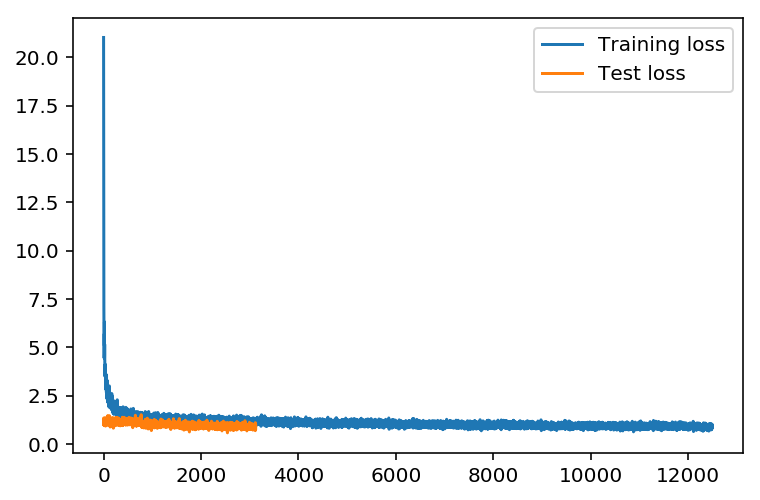

In [51]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['test'], label='Test loss')
plt.legend()
plt.ylim();

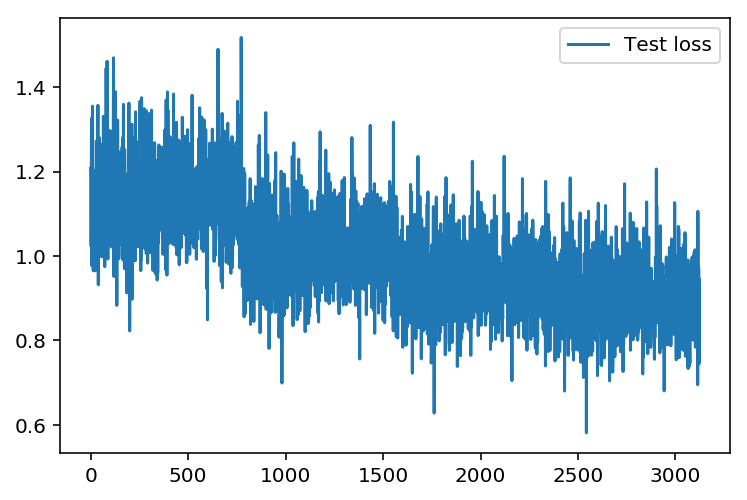

In [52]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
plt.ylim();

In [53]:
# TensorFlow Graph visualizer code
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [54]:
# Simply call this to display the result. Unfortunately it doesn't save the output together with
# the Jupyter notebook, so we can only show a non-interactive image here.
show_graph(train_graph)

In [55]:
def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params1.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params1.p', mode='rb'))

In [56]:
# save the model parameters for later use
save_params((save_dir))
load_dir = load_params()

# 4. Build Recommender System

### For new users: recommend new movies by searching similar movie titles
1. Use movie feature vectors
2. Calculate cosine similarity between each movie feature vector - each row (1, 200)
3. For each movie, find the top 20 similar movies by ranking the cosine similarity numbers
4. Return 5 of the top 20 randomly each time (higher rank, higher possibility to show up)
        
### For existing users: recommend new movies based on existing user data
1. For each user, use user feature vector * movie feature vectors (all movies)
2. Get the predicted movie ratings for new movies (for this user)
3. Find the top 20 recommended movies by ranking the predicted ratings
4. Return 5 of the top 20 randomly each time (higher ratings, higher possibility to show up)


In [58]:
# pull tensor out from the saved model
def get_tensors(loaded_graph):
    uid = loaded_graph.get_tensor_by_name('uid:0')
    user_gender = loaded_graph.get_tensor_by_name('user_gender:0')
    user_age = loaded_graph.get_tensor_by_name('user_age:0')
    user_job = loaded_graph.get_tensor_by_name('user_job:0')
    movie_id = loaded_graph.get_tensor_by_name('movie_id:0')
    movie_genres = loaded_graph.get_tensor_by_name('movie_genres:0')
    movie_titles = loaded_graph.get_tensor_by_name('movie_titles:0')
    targets = loaded_graph.get_tensor_by_name('targets:0')
    learning_rate = loaded_graph.get_tensor_by_name('learning_rate:0')
    dropout_rate = loaded_graph.get_tensor_by_name('dropout_rate:0')
    prediction = loaded_graph.get_tensor_by_name('prediction/ExpandDims:0')
    movie_fc = loaded_graph.get_tensor_by_name('movie_fc/Reshape:0')
    user_fc = loaded_graph.get_tensor_by_name('user_fc/Reshape:0')
    return uid, user_gender, user_age, user_job, movie_id, movie_genres, movie_titles, targets, learning_rate, dropout_rate,\
           prediction, movie_fc, user_fc

In [59]:
# rating prediction
def rating_prediction(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        # load the saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        # get all of the tensors from the loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_genres, movie_titles, targets, learning_rate, dropout_rate,\
        prediction, movie_fc, user_fc = get_tensors(loaded_graph)
        
        # get the dataset as feed
        feed = {
            uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
            user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
            user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
            user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
            movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
            movie_genres: np.reshape(movies.values[movieid2idx[movie_id_val]][2], [1, 6]),
            movie_titles: np.reshape(movies.values[movieid2idx[movie_id_val]][1], [1, sentences_size]),
            dropout_rate: 1 # no dropout layer
        }
        
        # get prediction
        prediction_val = sess.run(prediction, feed)
        
        return prediction_val      

In [60]:
rating_prediction(18, 1193).shape

(1, 1)

In [62]:
rating_prediction(1, 1193)

array([[4.7229176]], dtype=float32)

In [63]:
# get the users matrix
users_matrix = []
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    #load the saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    
    # get all of the tensors from the loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_genres, movie_titles, targets, learning_rate, dropout_rate,\
    prediction, movie_fc, user_fc = get_tensors(loaded_graph)
    
    # get the dataset as feed
    # run the users full connected tensor layers and get the users matrix
    
    for row in users.values:
        feed = {
            uid: np.reshape(row.take(0), [1, 1]),
            user_age: np.reshape(row.take(2), [1, 1]),
            user_gender: np.reshape(row.take(1), [1, 1]),
            user_job: np.reshape(row.take(3), [1, 1])
        }
        
        user_fc_val = sess.run(user_fc, feed) # shape (1, 200)
        users_matrix.append(user_fc_val)
    users_matrix = np.reshape(users_matrix, [-1, 200]) # shape (?, 200)

pickle.dump(users_matrix, open('users_matrix1.p', 'wb'))
users_matrix = pickle.load(open('users_matrix1.p', 'rb'))

In [64]:
users_matrix.shape

(6040, 200)

In [65]:
users_matrix

array([[-0.52489734,  0.00784611,  0.34323603, ...,  0.4989648 ,
        -0.12859493, -0.45927688],
       [-0.55560845, -0.16938806,  0.52514476, ...,  0.48875028,
         0.10018405, -0.41425306],
       [-0.19304268, -0.00720107,  0.3952153 , ...,  0.336664  ,
         0.0100918 , -0.13152845],
       ...,
       [-0.29473582, -0.23537777,  0.45361683, ...,  0.32675746,
        -0.0470682 , -0.1192058 ],
       [-0.02596044, -0.53301215,  0.32413405, ...,  0.5536361 ,
         0.1260052 , -0.40471387],
       [-0.21094753, -0.28952736,  0.332458  , ...,  0.43592766,
        -0.12140086, -0.2976466 ]], dtype=float32)

In [66]:
# get the movies matrix
movies_matrix = []
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    #load the saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    
    # get all of the tensors from the loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_genres, movie_titles, targets, learning_rate, dropout_rate,\
    prediction, movie_fc, user_fc = get_tensors(loaded_graph)
    
    # get the dataset as feed
    # run the users full connected tensor layers and get the movies matrix
    
    for row in movies.values:
        feed = {
            movie_id: np.reshape(row.take(0), [1, 1]),
            movie_genres: np.reshape(row.take(2), [1, 6]),
            movie_titles: np.reshape(row.take(1), [1, sentences_size]),
            dropout_rate: 1 
        }
        
        movie_fc_val = sess.run(movie_fc, feed) # shape (1, 200)
        movies_matrix.append(movie_fc_val)
    movies_matrix = np.reshape(movies_matrix, [-1, 200]) # shape (?, 200)

pickle.dump(movies_matrix, open('movies_matrix1.p', 'wb'))
movies_matrix = pickle.load(open('movies_matrix1.p', 'rb'))

In [67]:
movies_matrix.shape

(3883, 200)

In [68]:
movies_matrix

array([[-0.90074325,  0.9508319 , -0.926612  , ..., -0.6083266 ,
         0.94673157,  0.9067935 ],
       [-0.70166904,  0.95567095, -0.95380056, ..., -0.7044207 ,
         0.9023978 ,  0.9078961 ],
       [-0.944427  ,  0.98249304, -0.96785134, ..., -0.6171496 ,
         0.92678744,  0.94600767],
       ...,
       [-0.8920716 ,  0.94930714, -0.9376566 , ..., -0.33079028,
         0.89166063,  0.8927157 ],
       [-0.8507481 ,  0.96669793, -0.91524494, ..., -0.45175558,
         0.8805436 ,  0.8774147 ],
       [-0.9036425 ,  0.9263931 , -0.8228285 , ..., -0.28425142,
         0.9423345 ,  0.87693834]], dtype=float32)

In [118]:
# make sure movies_orig includs the original movie data
movies_title = ['MovieID', 'Title', 'Genres']
movies_orig = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies_orig.head()

MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

In [173]:
# make sure users_orig includs the original user data
users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
users_orig = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users_orig = users_orig.filter(regex='UserID|Gender|Age|JobID')
users_orig.head()

UserID Gender  Age  JobID
0       1      F    1     10
1       2      M   56     16
2       3      M   25     15
3       4      M   45      7
4       5      M   25     20

In [163]:
# build the recommender system
## recommend similar movies based on the movies matrix (cosine similarity)
def recommend_similar_movies(search, top_n = 20):
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        #load the saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        # according to the searched keyword, find the possible title names and movie ids
        for title in movies_orig.loc[movies_orig['Title'].str.contains(search, case=False),'Title'].values:
            movie_id_val = movies_orig.loc[movies_orig['Title']==title, 'MovieID'].values[0]
            
            # cosine similarity between the searched movieâ€˜s eigenvector and the entire movie matrix
            similarity = cosine_similarity(np.reshape(movies_matrix[movieid2idx[movie_id_val]],[1,200]),
                                           movies_matrix)[0]
            
            # random choice the movies from the top_n similar movies list and give recommendation
            similarity_prob = similarity
            similarity_prob[np.argsort(similarity_prob)[:-top_n]] = 0
            similarity_prob[np.argsort(similarity_prob)[-1]] = 0
            similarity_prob = similarity_prob / sum(similarity_prob)

            similar_movies_index = set()
            while len(similar_movies_index) != 5:
                n = np.random.choice(3883, 1, p=similarity_prob)[0]
                similar_movies_index.add(n)

            print('The movie you searched: ')
            print('')
            print('Movie ID: ', movies_orig.iloc[movieid2idx[movie_id_val]][0])
            print('Movie Title: ', movies_orig.iloc[movieid2idx[movie_id_val]][1])
            print('Movie Genres: ', movies_orig.iloc[movieid2idx[movie_id_val]][2])
            print('Average Rating: ', round(ratings[ratings['MovieID'] == movie_id_val]['Rating'].mean(),1))
            print('')
            print('Here are five movies you may like: ')
            print('')
            for i in similar_movies_index:
                print('Movie ID: ', movies_orig.iloc[i][0])
                print('Movie Title: ', movies_orig.iloc[i][1])
                print('Movie Genres: ', movies_orig.iloc[i][2])
                print('Average Rating: ', round(ratings[ratings['MovieID'] == movies_orig.iloc[i][0]]['Rating'].mean(),1))
                print('---------------')
                print('')
                

In [164]:
recommend_similar_movies('star war')

The movie you searched: 

Movie ID:  260
Movie Title:  Star Wars: Episode IV - A New Hope (1977)
Movie Genres:  Action|Adventure|Fantasy|Sci-Fi
Average Rating:  4.5

Here are five movies you may like: 

Movie ID:  1371
Movie Title:  Star Trek: The Motion Picture (1979)
Movie Genres:  Action|Adventure|Sci-Fi
Average Rating:  3.1
---------------

Movie ID:  1372
Movie Title:  Star Trek VI: The Undiscovered Country (1991)
Movie Genres:  Action|Adventure|Sci-Fi
Average Rating:  3.4
---------------

Movie ID:  1375
Movie Title:  Star Trek III: The Search for Spock (1984)
Movie Genres:  Action|Adventure|Sci-Fi
Average Rating:  3.4
---------------

Movie ID:  2043
Movie Title:  Darby O'Gill and the Little People (1959)
Movie Genres:  Adventure|Children's|Fantasy
Average Rating:  3.3
---------------

Movie ID:  1356
Movie Title:  Star Trek: First Contact (1996)
Movie Genres:  Action|Adventure|Sci-Fi
Average Rating:  3.7
---------------

The movie you searched: 

Movie ID:  1196
Movie Title:  S

In [165]:
# build the recommender system
## recommend the movie you like based on the ratings
def recommend_your_favorate_movies(user_id, top_n = 20):
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        #load the saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        # get all of the tensors from the loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_genres, movie_titles, targets, learning_rate, dropout_rate,\
        prediction, movie_fc, user_fc = get_tensors(loaded_graph)
        
        user_matrix_combine = np.zeros([3883,200])
        for i in range(3883):
            user_matrix_combine[i] = users_matrix[user_id-1]
        user_matrix_combine = user_matrix_combine.astype('float32')
        
        # get the ratings matrix (predictions) for the particular user
        prediction_matrix = np.add.reduce(user_matrix_combine * movies_matrix, axis=1)
        
        # random choice the movies from the top_n similar movies list and give recommendation
        top_movies = prediction_matrix
        for m in ratings_orig.loc[ratings_orig['UserID']==user_id].MovieID.tolist():
            top_movies[movieid2idx[m]]=0
        top_movies[np.argsort(top_movies)[:-top_n]] = 0
        top_movies = top_movies / sum(top_movies)
        
        top_movies_index = set()
        while len(top_movies_index) != 5:
            n = np.random.choice(3883, 1, p=top_movies)[0]
            top_movies_index.add(n)

        print('Here is your profile: ')
        print('')
        print('User ID: ', users_orig.iloc[user_id-1][0])
        print('User Gender: ', users_orig.iloc[user_id-1][1])
        print('User Age: ', users_orig.iloc[user_id-1][2])
        print('Average Rating: ', round(ratings[ratings['UserID']==user_id]['Rating'].mean(),1))
        print('')
        print('Here are five movies you may like: ')
        print('')
        for i in top_movies_index: # i is the index of the movies in the movies_matrix
            print('Movie ID: ', movies_orig.iloc[i][0])
            print('Movie Title: ', movies_orig.iloc[i][1])
            print('Movie Genres: ', movies_orig.iloc[i][2])
            print('Average Rating: ', round(ratings[ratings['MovieID'] == movies_orig.iloc[i][0]]['Rating'].mean(),1))
            print('---------------')
            print('')
        

In [174]:
recommend_your_favorate_movies(4, top_n = 20)

Here is your profile: 

User ID:  4
User Gender:  M
User Age:  45
Average Rating:  4.2

Here are five movies you may like: 

Movie ID:  750
Movie Title:  Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
Movie Genres:  Sci-Fi|War
Average Rating:  4.4
---------------

Movie ID:  913
Movie Title:  Maltese Falcon, The (1941)
Movie Genres:  Film-Noir|Mystery
Average Rating:  4.4
---------------

Movie ID:  3435
Movie Title:  Double Indemnity (1944)
Movie Genres:  Crime|Film-Noir
Average Rating:  4.4
---------------

Movie ID:  1207
Movie Title:  To Kill a Mockingbird (1962)
Movie Genres:  Drama
Average Rating:  4.4
---------------

Movie ID:  1284
Movie Title:  Big Sleep, The (1946)
Movie Genres:  Film-Noir|Mystery
Average Rating:  4.3
---------------



# 5. Showcases
 ![4](./pic/4.png)
 ![5](./pic/5.png)

# 6. Next Step
1. Train the model on a bigger dataset, add more movies
2. Explore other models (e.g. SVD) and compare the score
3. Build an user interface for better interactions
